In [4]:
import sys
sys.path.append('../modules')

from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from interpolator import *
from gridding import *
from mapper import *
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import cartopy.feature
import seaborn as sns
import pandas as pd


%load_ext autoreload
%autoreload 2
%page
%alias_magic t timeit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


''

In [6]:
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/hdd/*.nc'
#PATH = '/home/nannau/Desktop/ensembles/jan1.0p/*'
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jul2.5p/*.nc'

PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'

test_file = xr.open_dataset(PATH)
test_file = test_file.rename({'time':'run'})
ds = test_file.rename({'snw':'dv'})

In [7]:
dv_field = ds['dv'].values.copy()
ens = ens_flat(dv_field)
rlat, rlon = ds['rlat'].values, ds['rlon'].values

In [8]:
coordict = gen_new_coords(rlat, rlon, 10)

In [76]:
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'

mask_land = load_land_mask(mask_path)
mask_master = mask_land_and_nan(dv_field, mask_land)
idx = flatten_mask(mask_master)

imask_master = interpolate_land_mask(dv_field=dv_field, path=mask_path)
imask = flatten_interpolated_land_mask(imask_master, coordict['irlat'], coordict['irlon'])

iidx = flatten_mask(imask)
idx.shape, idx.shape
# mask_master.shape, imask.shape

NameError: name 'xr' is not defined

In [23]:
#idx = imask == True
#idx.shape
points = coordict['icoordens'][iidx]
irlon, irlat = coordict['irlon'], coordict['irlat']

In [73]:
iens = np.broadcast_to(np.reshape(imask, 
                                 (irlon.shape[0]*irlat.shape[0])), 
                       (dv_field.shape[0], irlon.shape[0]*irlat.shape[0])).copy().astype(float)
coordends = coordict['coordens']

In [25]:
#points = icoordens[idx]

for i in range(dv_field.shape[0]):
    iens[i, iidx] = interpolate.griddata(coordict['coordens'][idx], ens[i, idx], points, method='linear')

iens.shape, ens.shape

((35, 2015000), (35, 20150))

In [77]:
##nan_mask = np.apply_over_axes(
#                np.logical_or.reduce,
#                np.isnan(iens),
#                (0)
#)

#master_idx = ~np.logical_or(~imask_master, nan_mask).flatten()

iens[:, imaster_idx]

NameError: name 'imaster_idx' is not defined

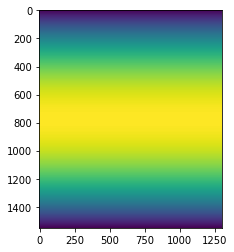

In [28]:
area = frac_grid_area(irlon, irlat)
area_relevent_grid_cells = area.reshape(1, -1)
area_relevent_grid_cells.shape
plt.imshow(area)

In [49]:
#mean = iens.mean(axis=0).reshape(1, -1)
mean = iens.mean(axis=0)[master_idx].reshape(1, -1)

In [56]:
#corr_ens = (iens[master_idx] - mean[:, master_idx])*area_relevent_grid_cells[master_idx]
corr_ens = (iens[:, master_idx] - mean)*area_relevent_grid_cells[:, master_idx]      

#corr_ens = corr_ens[:, master_idx]

In [57]:
ens_eof = ens_to_eof(corr_ens).components_
#corr_ens_full_size[:ens_eof.shape[0], idx] = ens_eof

print("EOF Shape: ", ens_eof.shape)
type(ens_to_eof(corr_ens))

EOF Shape:  (28, 628708)


sklearn.decomposition.pca.PCA

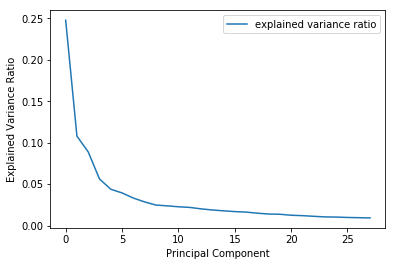

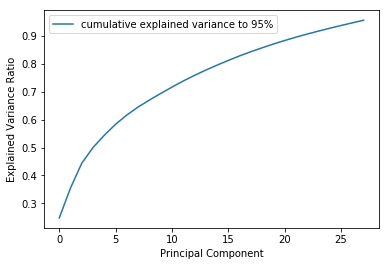

In [58]:
sns.lineplot(range(ens_eof.shape[0]), 
             ens_to_eof(corr_ens).explained_variance_ratio_, 
             label='explained variance ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
sns.lineplot(range(ens_eof.shape[0]), 
             np.cumsum(ens_to_eof(corr_ens).explained_variance_ratio_),
             label='cumulative explained variance to 95%')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [59]:
rcoord_ens_dict = rlat_rlon_to_ens(irlat, irlon)
rlat_ens = rcoord_ens_dict['rlat'][master_idx]
rlon_ens = rcoord_ens_dict['rlon'][master_idx]

lat_lon_ens = np.array(list(zip(rlat_ens, rlon_ens)))
len(lat_lon_ens)

628708

In [60]:
df = pd.read_csv('/storage/data/projects/nrc/station_data/snow_load/swe_rl50_stations_test.csv', index_col=None)
df.head()

,id,station_name,lat,lon,prov,snow_load_rl50
0,2193,EUREKA A,79.9833,-85.9333,NU,0.936965
1,2027,TUKTOYAKTUK,69.4500,-133.0000,NT,1.815147
2,2029,TUKTOYAKTUK A,69.4333,-133.0260,NT,2.158906
3,2064,BAKER LAKE A,64.2989,-96.0778,NU,3.265956
4,2072,CHESTERFIELD,63.3333,-90.7167,NU,3.314342


In [61]:
#df = df[df['completeness'] > 0.8]

In [62]:
lat_lon_obs = list(zip(df['lat'], df['lon']))
lat_obs, lon_obs = zip(*lat_lon_obs)

coords = to_rotated(lat_obs, lon_obs)
rlat_obs, rlon_obs = np.array(coords['rlat_obs']), np.array(coords['rlon_obs'])

lat_lon_obs = list(zip(rlat_obs, rlon_obs))

In [63]:
%%time
df['nearest_grid'] = dist_index(np.array(lat_lon_obs), np.array(lat_lon_ens))
print
df.head()

CPU times: user 6.09 s, sys: 1.74 s, total: 7.83 s
Wall time: 4.86 s


,id,station_name,lat,lon,prov,snow_load_rl50,nearest_grid
0,2193,EUREKA A,79.9833,-85.9333,NU,0.936965,387519
1,2027,TUKTOYAKTUK,69.4500,-133.0000,NT,1.815147,469445
2,2029,TUKTOYAKTUK A,69.4333,-133.0260,NT,2.158906,485882
3,2064,BAKER LAKE A,64.2989,-96.0778,NU,3.265956,341555
4,2072,CHESTERFIELD,63.3333,-90.7167,NU,3.314342,494701


In [64]:
#df = df[df['completeness']>0.80]
ndf = df.groupby('nearest_grid').agg({'snow_load_rl50': 'mean', 'lat':'min', 'lon':'min'})#, 'completeness':'min'})

In [65]:
ndf.index

Int64Index([ 76922,  79138,  80695,  83623,  91428,  92922,  93045,  93768,
             93816,  94485,
            ...
            598505, 603767, 605263, 606041, 609017, 611059, 616225, 620289,
            622801, 628046],
           dtype='int64', name='nearest_grid', length=525)

In [66]:
# create an array containing the indices in ensemble space
# of the corresponding observed design values
match_ens_obs_idx = np.asarray(ndf.index)
match_obs_ens = (np.array(ndf.snow_load_rl50)-mean[:, match_ens_obs_idx])*area_relevent_grid_cells[:, match_ens_obs_idx]
match_model_ens = ens_eof[:, match_ens_obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens.shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (28, 525) 
Matched Obs shape:  (1, 525)


In [67]:
model = regress_eof(match_model_ens.T, match_obs_ens.flatten())

predictions = predict_dv(model, ens_eof.T)
latlist, lonlist = zip(*list(lat_lon_ens))

observations = match_obs_ens.flatten()#/area_relevent_grid_cells[:, match_ens_obs_idx] 
reconstructed_observations = predictions[match_ens_obs_idx]#/area_relevent_grid_cells[:, match_ens_obs_idx]

Regressed model score: 0.6085607931494323


In [68]:
observations.shape, reconstructed_observations.shape

((525,), (525,))

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.reshape(-1, 1), reconstructed_observations.reshape(-1, 1))

print("slope", regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.reshape(-1, 1))
# model evaluation
observations[:5], reconstructed_observations[:5]

slope 0.6085607931494322


(array([1.34295778e-07, 2.27242749e-07, 1.03938530e-07, 2.14732583e-07,
        2.25361773e-06]),
 array([-1.08978203e-07, -2.79388889e-07,  1.89211516e-07,  1.02207024e-06,
         7.41464804e-07]))

Text(0, 0.5, 'Reconstruction')

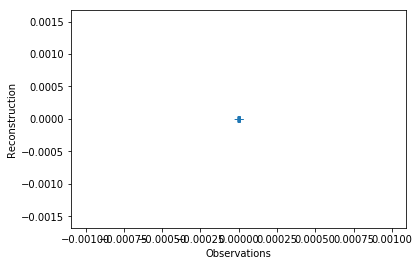

In [72]:
#ax = sns.jointplot(ens[0, match_ens_obs_idx], np.array(ndf), kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(observations, 
                reconstructed_observations, 
                palette="viridis",
                marker='+'
)
#sns.lineplot(np.array(ndf), np.array(ndf), 
#             color='r')
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

## Let's have some cluster fun

In [42]:
#nearest_rlon = np.array([find_nearest(irlon, obs) for obs in rlon_obs])
#nearest_rlat = np.array([find_nearest(irlat, obs) for obs in rlat_obs])

#def calculate_flat_index(rlat_idx, rlon_idx, max_shape):
#    return rlon_idx*rlat_idx+(max_shape-rlon_idx)*(rlat_idx-1)


#C=calculate_flat_index(nearest_rlon, nearest_rlat, irlat.shape[0])
#np.where(C >= len(lat_lon_ens)), C
#print
#lat_lon_ens_spots = np.array(list(zip(irlat[nearest_rlat], irlon[nearest_rlon])))
#irlat[nearest_rlat]
#rlat_match, rlon_match = irlat[nearest_rlat], irlon[nearest_rlon]
#lat_lon_ens.shape, lat_lon_ens_spots.shape
#np.where(lat_lon_ens_spots==lat_lon_ens)
#idxxs = np.intersect1d(lat_lon_ens, lat_lon_ens_spots, return_indices=True)[1]

#idxxs.shape, lat_lon_ens_spots.shape

#nrows, ncols = lat_lon_ens.shape
#dtype={'names':['f{}'.format(i) for i in range(ncols)],
#       'formats':ncols * [lat_lon_ens_spots.dtype]}

#C = np.intersect1d(lat_lon_ens.view(dtype), lat_lon_ens_spots.view(dtype), return_indices=True)[1]
#ens_eof[:, C].shape, idxxs.shape

In [43]:
df.head()

,id,station_name,lat,lon,prov,snow_load_rl50,nearest_grid
0,2193,EUREKA A,79.9833,-85.9333,NU,0.936965,387519
1,2027,TUKTOYAKTUK,69.4500,-133.0000,NT,1.815147,469445
2,2029,TUKTOYAKTUK A,69.4333,-133.0260,NT,2.158906,485882
3,2064,BAKER LAKE A,64.2989,-96.0778,NU,3.265956,341555
4,2072,CHESTERFIELD,63.3333,-90.7167,NU,3.314342,494701


In [44]:
ndf = df.groupby('nearest_grid').agg({'snow_load_rl50': 'mean', 'lat':'min', 'lon':'min'})#, 'completeness':'min'})

X = ndf[['snow_load_rl50']].values
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(damping=0.8).fit(X)
ndf['labels'] = clustering.labels_

In [37]:
ndf.shape[0], df.shape[0]

(1719, 1768)

In [38]:
match_ens_obs_idx = np.asarray(ndf.index)

In [40]:
match_obs_ens = (np.array(ndf['quantile']))*area_relevent_grid_cells[:, match_ens_obs_idx] #- mean[:, match_ens_obs_idx])#*area_relevent_grid_cells[:, match_ens_obs_idx]
match_model_ens = ens_eof[:, match_ens_obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (25, 1719) 
Matched Obs shape:  (1719,)


In [41]:
model = regress_eof(match_model_ens.T, match_obs_ens[0, :])

Regressed model score: 0.5042543341057097


In [42]:
match_model_ens.shape

(25, 1719)

In [43]:
predictions = predict_dv(model, ens_eof.T)

In [44]:
latlist, lonlist = zip(*list(lat_lon_ens))

In [55]:
observations = match_obs_ens/area_relevent_grid_cells[:, match_ens_obs_idx] 
reconstructed_observations = predictions[match_ens_obs_idx]/area_relevent_grid_cells[:, match_ens_obs_idx]
d = {'obs': observations.flatten(), 
     'reconstructed_obs': reconstructed_observations.flatten(), 
     'lat': ndf['lat'], 
     'lon': ndf['lon'], 
     #'completeness': ndf['completeness'], 
     'model': match_model_ens[0, :],
     'fancy_frac': match_model_ens[0, :]/match_obs_ens[0, :]}
df_eof = pd.DataFrame(d)

X = df_eof[['lat', 'lon', 'obs']].values
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering


#clustering = AgglomerativeClustering(n_clusters=3).fit(X)
#clustering = AffinityPropagation(damping=0.98).fit(X)
#clustering = DBSCAN(eps=100, min_samples=30).fit(X)
clustering = OPTICS(eps=100, min_samples=30).fit(X)
df_eof['labels'] = clustering.labels_

df_eof['labels'].unique()#

array([-1,  1,  0,  2,  4,  3])

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

for label in df_eof['labels'].unique():
    df_eof_tmp = df_eof[df_eof['labels'] == label]
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(df_eof_tmp['obs'].values.reshape(-1, 1), df_eof_tmp['reconstructed_obs'].values.reshape(-1, 1))
    
    y_predicted = regression_model.predict(df_eof_tmp['obs'].values.reshape(-1, 1))

    r2 = r2_score(df_eof_tmp['reconstructed_obs'], y_predicted)
    print("Label",label, "slope", regression_model.coef_[0][0], 'r2 of linear fit', r2)
    
#ndf['labels'].values.shape, observations.shape

Label -1 slope 0.49727340680094356 r2 of linear fit 0.36460556488417506
Label 1 slope -0.2726281548740126 r2 of linear fit 0.023289769833278684
Label 0 slope 0.7743416815403348 r2 of linear fit 0.04167613238249501
Label 2 slope -0.398822930750705 r2 of linear fit 0.022473310906962807
Label 4 slope -0.07339207636930134 r2 of linear fit 0.0008019893339253903
Label 3 slope 0.6908137398887964 r2 of linear fit 0.047722672000438116


In [57]:
df_eof.head()

,obs,reconstructed_obs,lat,lon,model,fancy_frac,labels
nearest_grid,,,,,,,
264612,-105.000,-124.698525,42.1034,-83.0945,-0.001041,20.780752,-1
269640,-115.835,-116.182073,42.0333,-82.9000,-0.000826,14.919555,-1
278083,-117.500,-177.702324,42.4500,-81.8833,-0.000684,12.161492,-1
285749,-123.000,-140.494693,42.3000,-82.7000,-0.000804,13.623302,-1
291845,-135.000,-186.491512,42.9806,-81.6428,-0.000560,8.634363,-1


['-1' '1' '0' '2' '4' '3']


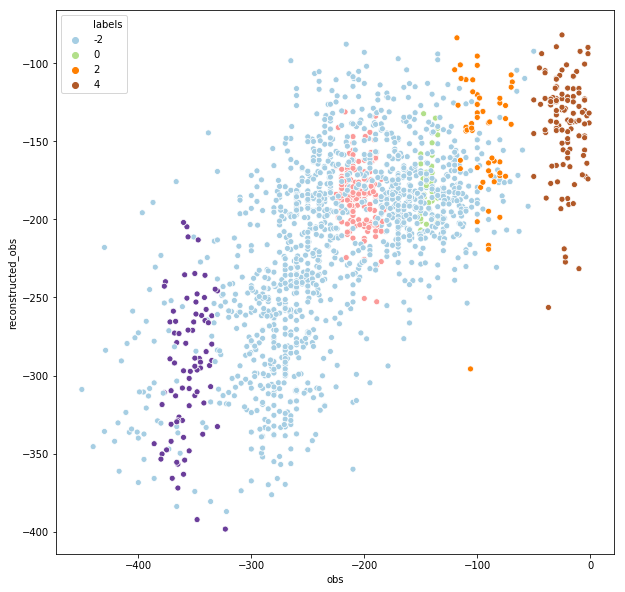

In [58]:
marker = df_eof['labels'].unique().astype(str)
print(marker)
#markers = [marker[i] for i in range(len(df["labels"].unique()))]
plt.figure(figsize=(10,10))
sns.scatterplot(
    'obs', 
    'reconstructed_obs',
    data=df_eof,
    hue='labels',
    palette='Paired'
)
plt.show()


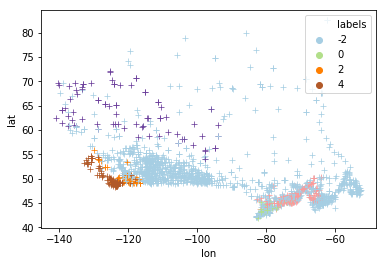

In [59]:
ax = sns.scatterplot(df_eof['lon'], df_eof['lat'],marker='+', hue=df_eof['labels'], palette="Paired")

Label 3 slope 0.7743416815403348 r2 of linear fit 0.04167613238249501 members 32


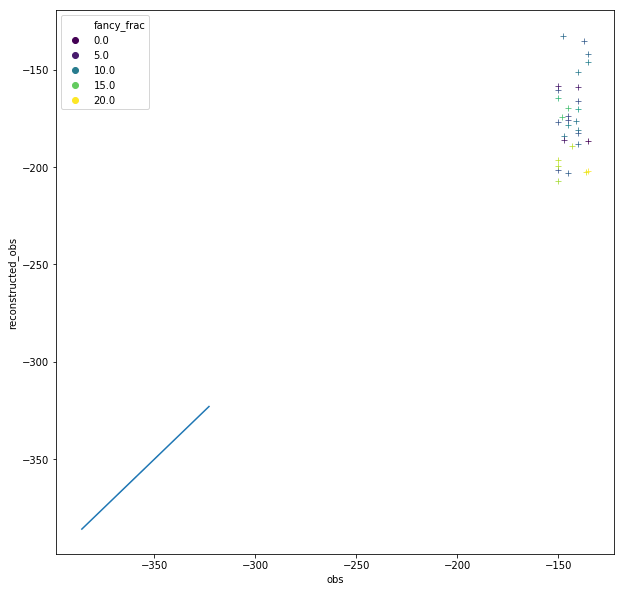

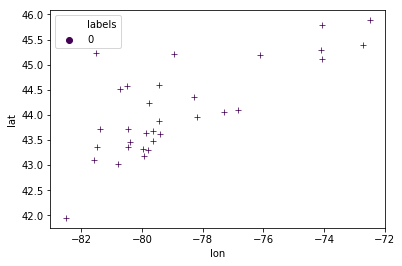

In [60]:
plt.figure(figsize=(10,10))
sns.lineplot(df_eof_tmp['obs'], df_eof_tmp['obs'],)
df_eof_tmp = df_eof[(df_eof['labels'] == 0)]
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(df_eof_tmp['obs'].values.reshape(-1, 1), df_eof_tmp['reconstructed_obs'].values.reshape(-1, 1))

y_predicted = regression_model.predict(df_eof_tmp['obs'].values.reshape(-1, 1))

r2 = r2_score(df_eof_tmp['reconstructed_obs'], y_predicted)
print("Label",label, "slope", regression_model.coef_[0][0], 'r2 of linear fit', r2, 'members', df_eof_tmp.shape[0])
sns.scatterplot(df_eof_tmp['obs'], 
                df_eof_tmp['reconstructed_obs'], 
                hue=df_eof_tmp['fancy_frac'], 
                palette="viridis",
                marker='+'
)
plt.show()
ax = sns.scatterplot(df_eof_tmp['lon'], df_eof_tmp['lat'],marker='+', hue=df_eof_tmp['labels'], palette="viridis")

In [790]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print("slope", regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('EOF Score', model.score(match_model_ens.T, match_obs_ens[0, :]))
print('rmse', rmse)
print('r2 of linear fit', r2)

observations.T[:, 0]
np.polyfit(observations.T[:, 0], reconstructed_observations.T[:, 0], 1)

slope 0.6081837704213895
EOF Score 0.63683471360212
rmse 433059.3129319769
r2 of linear fit 0.6077024250203193


array([6.08183770e-01, 1.69136419e+03])

IndexError: index 262901 is out of bounds for axis 0 with size 592

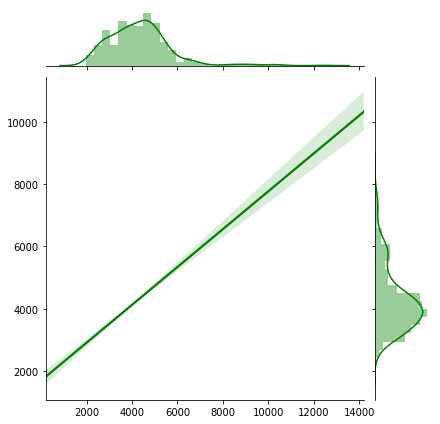

In [791]:
ax = sns.jointplot(observations.T[:, 0], reconstructed_observations.T[:, 0], kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(observations.T[:, 0], 
                reconstructed_observations.T[:, 0], 
                hue=ndf['labels'].values[match_ens_obs_idx], 
                palette="viridis",
                marker='+'
)
sns.lineplot(observations.T[:, 0], 
             observations.T[:, 0], 
             color='r')
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

In [ ]:
# Now it's time to plot!
